In [32]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import rpy2.robjects as robj
import pyreadr
from easydict import EasyDict as edict
from tqdm import tqdm_notebook as tqdm
import sys
import time as Time
import pickle
from scipy.io import loadmat
from scipy.signal import decimate, detrend
import seaborn as sns
from pathlib import Path
%matplotlib inline

In [33]:
sys.path.append("/home/huaqingj/MyResearch/dynamicR2py")
from utils import *

In [34]:
resDir = Path("./results")
dataDir = Path("./data")

In [35]:
filname = Path("subj2.mat")
MEG = loadmat(dataDir/filname)["DK_timecourse"]

In [36]:
#Rate when doing decimate 
rate = 10 
#MEG = detrend(MEG) # The data are already detrended
#MEG = decimate(MEG, q=rate)
MEGlist = []
for i in range(MEG.shape[0]):
    MEGlist.append(decimate_R(MEG[i, :], rate))
MEG = np.array(MEGlist)

## Detection

### detection parameters

In [37]:
kappa = 2.95
r = 8
Lmin = 60
# Down sample rate when estimating A matrix
downrate = 20 
MaxM = 19
lamb = 1e-4
fct = 0.5
d, n = MEG.shape
time = np.linspace(0, 2, n)
paras = {"kappa":kappa, "Lmin":Lmin, "r":r, "downrate":downrate, "MaxM":MaxM, "lamb":lamb, "rate":rate}

### detection

In [38]:
resFil = resDir/f"{filname.stem}_Rank{r}.pkl"

In [39]:
if not resFil.exists():
    t0 = Time()
    dXmat, Xmat = GetBsplienEst(MEG, time, lamb=lamb)
    Amat = GetAmat(dXmat, Xmat, time, downrate, fct=fct)
    midRes = GetNewEst(dXmat, Xmat, Amat, r=r, is_full=True)
    ndXmat, nXmat = midRes.ndXmat, midRes.nXmat
    finalRes = EGenDy(ndXmat, nXmat, kappa=kappa, Lmin=Lmin, MaxM=MaxM, diag=True)
    tc = Time()
    MEGRes = edict()
    MEGRes.PostMEG = MEG
    MEGRes.midRes = midRes
    MEGRes.finalRes = finalRes
    MEGRes.Amat = Amat
    MEGRes.dXmat = dXmat
    MEGRes.Xmat = Xmat
    MEGRes.paras = paras
    print(f"The running time is {tc-t0:.3f}.")
    with open(resFil, "wb") as f:
        pickle.dump(MEGRes, f)
else:
    with open(resFil, "rb") as f:
        MEGRes = pickle.load(f)
    

In [40]:
MEGRes.finalRes.mbic_ecpts.shape

(0,)

### Draw the change points curve

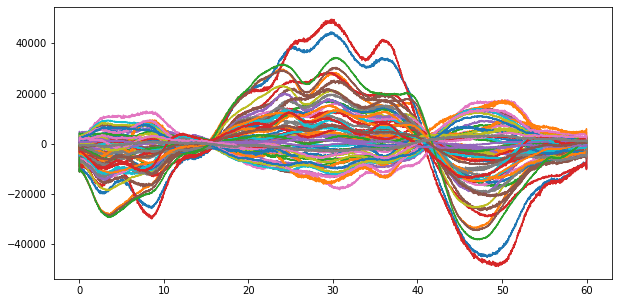

In [41]:
plt.figure(figsize=[10, 5])
ptime = np.linspace(0, 60, n)
for i in range(d):
    plt.plot(ptime, MEG[i, :], "-")
for ecpt in MEGRes.finalRes.mbic_ecpts:
    plt.axvline(ecpt/60, color="black", linestyle="-.")

### Plot the Reconstructed Curve

In [42]:
RecMEGfil = resDir/f"{filname.stem}_Rank{r}_Rec.pkl"

In [45]:
if not RecMEGfil.exists():
    t0 = Time()
    finalRes = MEGRes.finalRes
    midRes = MEGRes.midRes
    tStep = np.diff(time)[0]
    ecpts = finalRes.mbic_ecpts
    ndXmat = midRes.ndXmat
    nXmat = midRes.nXmat
    kpidxs = midRes.kpidxs
    eigVecs = midRes.eigVecs
    RecRes = ReconXmat(ecpts, ndXmat, nXmat, kpidxs, eigVecs, MEG, tStep, r=r, is_full=True) 
    tc = Time()
    print(f"The consumed time is {tc-t0:.2f}s.")
    with open(RecMEGfil, "wb") as f:
        pickle.dump(RecRes, f)
else:
    with open(RecMEGfil, "rb") as f:
        RecRes = pickle.load(f)
RecMEG = RecRes.EstXmatReal


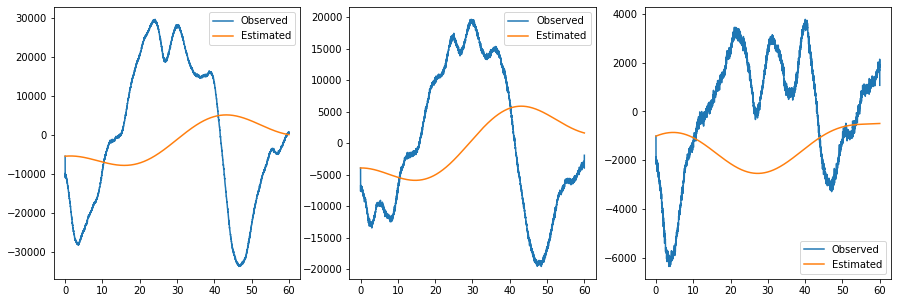

In [46]:
ptime = np.linspace(0, 60, n)
plt.figure(figsize=[15, 5])

plt.subplot(1, 3, 1)
#plt.plot(ptime, MEG[66, :], label="Observed")
#plt.plot(ptime, RecMEG[66, :], label="Estimated")
plt.plot(ptime, MEG[1, :], label="Observed")
plt.plot(ptime, RecMEG[1, :], label="Estimated")
_ = plt.legend()

plt.subplot(1, 3, 2)
plt.plot(ptime, MEG[47, :], label="Observed")
plt.plot(ptime, RecMEG[47, :], label="Estimated")
_ = plt.legend()

plt.subplot(1, 3, 3)
plt.plot(ptime, MEG[52, :], label="Observed")
plt.plot(ptime, RecMEG[52, :], label="Estimated")
_ = plt.legend()

### Draw the eigen value curve

In [47]:
freq = 60 
ReLamMs = RecRes.LamMs.real*freq/30 
ImLamMs = RecRes.LamMs.imag*freq /(30*2*np.pi)

In [48]:
linestyles = [  ('dotted',                (0, (1, 1))),
     ('densely dotted',        (0, (1, 1))),

     ('dashed',                (0, (5, 5))),
     ('densely dashed',        (0, (5, 1))),

     ('dashdotted',            (0, (3, 5, 1, 5))),
     ('densely dashdotted',    (0, (3, 1, 1, 1))),

     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))] 
cols = sns.color_palette("Paired", ReLamMs.shape[0])
#cols = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]

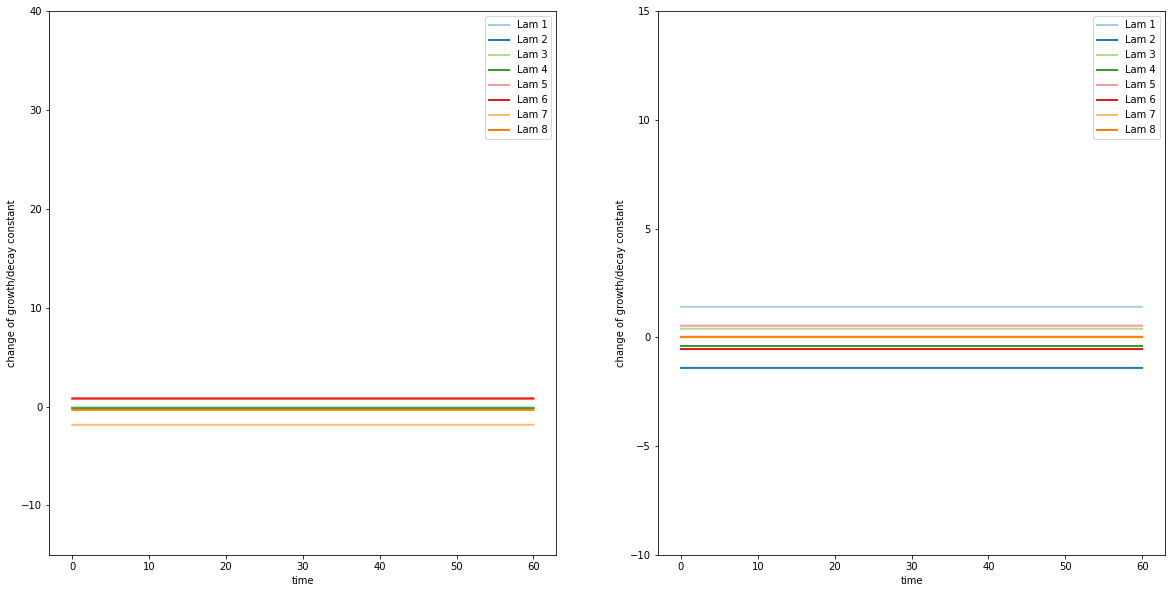

In [51]:
plt.figure(figsize=[20,10])

plt.subplot(121)
for i in range(ReLamMs.shape[0]):
    plt.plot(ptime, ReLamMs[i, :], label=f"Lam {i+1}", #linestyle=linestyles[i+1][-1], 
             color=cols[i], linewidth=2)
plt.ylim([-15, 40])
plt.ylabel("change of growth/decay constant")
plt.xlabel("time")
_ = plt.legend()

plt.subplot(122)
for i in range(ReLamMs.shape[0]):
    plt.plot(ptime, ImLamMs[i, :], label=f"Lam {i+1}", #linestyle=linestyles[i][-1], 
             color=cols[i], linewidth=2)
plt.ylim([-10, 15])
plt.ylabel("change of growth/decay constant")
plt.xlabel("time")
_ = plt.legend()

### Kappa tuning

In [52]:
kappas = np.linspace(2.5, 3, 100)

In [53]:
U0 = MEGRes.finalRes.U0

In [54]:
rAct = MEGRes.midRes.nXmat.shape[0]
U0s = []
for kappac in kappas:
    U0s.append(U0 + 2*rAct*np.log(n)**kappac* (np.arange(1, MaxM+2)))
U0s = np.array(U0s)

In [55]:
numchgs = U0s.argmin(axis=1)

In [ ]:
numchgs

### Plot kappa vs num of change points

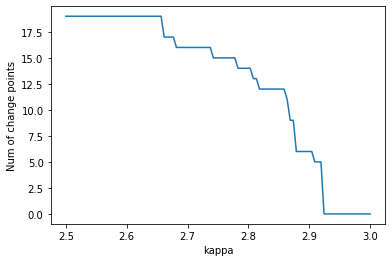

In [56]:
plt.plot(kappas, numchgs)
plt.ylabel("Num of change points")
_ = plt.xlabel("kappa")

In [58]:
RecMEGAllfil = resDir/f"{filname.stem}_Rank{r}_RecAll.pkl"

In [59]:
RecMEGAll = []
if not RecMEGAllfil.exists():
    for numchg in range(20):
        print(f"Current number of change point is {numchg}.")
        finalRes = MEGRes.finalRes
        midRes = MEGRes.midRes
        t0 = Time()
        tStep = np.diff(time)[0]
        ndXmat = midRes.ndXmat
        nXmat = midRes.nXmat
        kpidxs = midRes.kpidxs
        eigVecs = midRes.eigVecs
        if numchg == 0:
            RecResCur = ReconXmat([], ndXmat, nXmat, kpidxs, eigVecs, MEG, tStep, r=r, is_full=True) 
        else:
            RecResCur = ReconXmat(finalRes.chgMat[numchg-1, :numchg], ndXmat, nXmat, kpidxs, eigVecs, MEG, tStep, r=r, is_full=True) 
        RecMEGAll.append(RecResCur)
    with open(RecMEGAllfil, "wb") as f:
        pickle.dump(RecMEGAll, f)
else:
    with open(RecMEGAllfil, "rb") as f:
        RecMEGAll = pickle.load(f)

Current number of change point is 0.
Current number of change point is 1.
Current number of change point is 2.
Current number of change point is 3.
Current number of change point is 4.
Current number of change point is 5.
Current number of change point is 6.
Current number of change point is 7.
Current number of change point is 8.
Current number of change point is 9.
Current number of change point is 10.
Current number of change point is 11.
Current number of change point is 12.
Current number of change point is 13.
Current number of change point is 14.
Current number of change point is 15.
Current number of change point is 16.
Current number of change point is 17.
Current number of change point is 18.
Current number of change point is 19.


### Obtain MSE for each kappa

In [60]:
MSEs = []
for i in range(20):
    RecMEGCur = RecMEGAll[i].EstXmatReal
    MSE = np.mean((RecMEGCur-MEG)**2)
    MSEs.append(MSE)

In [61]:
MSEs

[106250305.37325364,
 106342763.08406955,
 112008995.10591239,
 92132676.77664813,
 103506310.54327333,
 101944888.09679009,
 100514763.08256528,
 107408486.16443628,
 152661264.0844145,
 122585214.50895052,
 92245802.89397511,
 304179487.7257734,
 17307844.23174704,
 11995013.423927998,
 12304282.339061918,
 18637759.691775963,
 23243564.914949574,
 19664517.61252856,
 19519328.25589151,
 19777788.890247293]

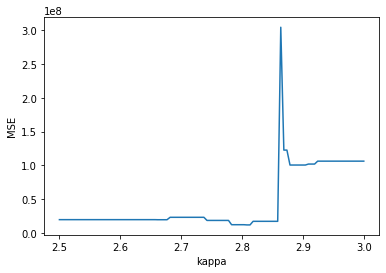

In [62]:
MSEsKappa = [MSEs[i] for i in numchgs]
plt.plot(kappas, MSEsKappa)
plt.ylabel("MSE")
_ = plt.xlabel("kappa")

### Draw the change points curve when the MSE is minial

In [63]:
optNumChg = np.argmin(MSEs);optNumChg

13

### The optimal kappa w.r.t MSE

In [73]:
kappas[numchgs==optNumChg]

array([2.80808081, 2.81313131])

In [64]:
ecpts_opt = MEGRes.finalRes.chgMat[optNumChg-1, :optNumChg]

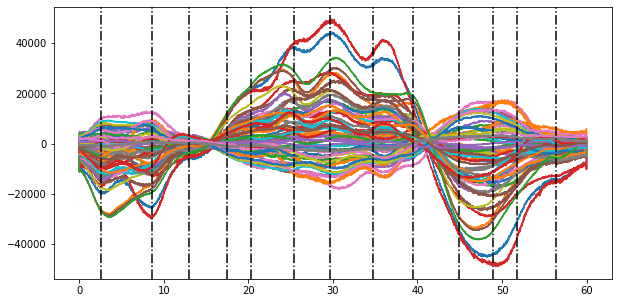

In [65]:
plt.figure(figsize=[10, 5])
ptime = np.linspace(0, 60, n)
for i in range(d):
    plt.plot(ptime, MEG[i, :], "-")
for ecpt in ecpts_opt:
    plt.axvline(ecpt/60, color="black", linestyle="-.")

### Draw the reconstructed curve under optimal kappa

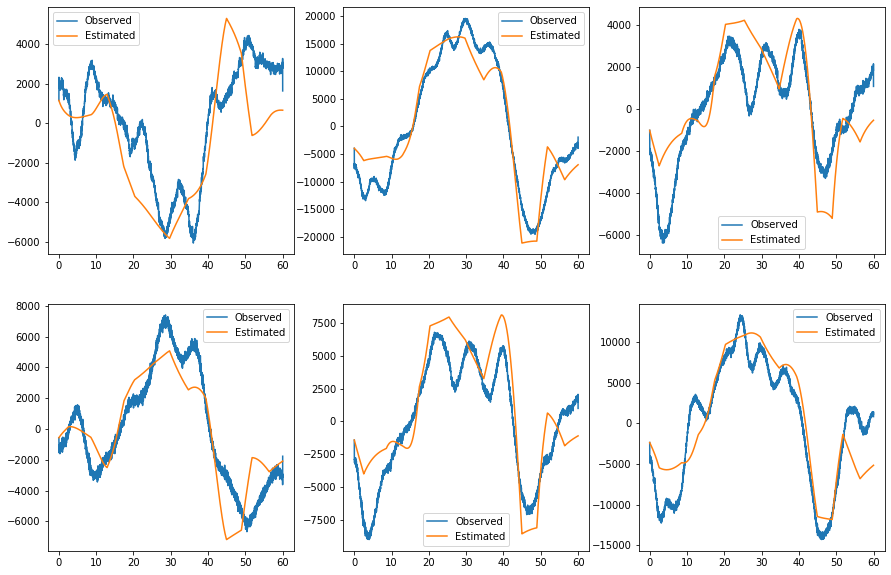

In [71]:
ptime = np.linspace(0, 60, n)
plt.figure(figsize=[15, 10])

plt.subplot(2, 3, 1)
plt.plot(ptime, MEG[66, :], label="Observed")
plt.plot(ptime, RecMEGAll[optNumChg].EstXmatReal[66, :], label="Estimated")
_ = plt.legend()

plt.subplot(2, 3, 2)
plt.plot(ptime, MEG[47, :], label="Observed")
plt.plot(ptime, RecMEGAll[optNumChg].EstXmatReal[47, :], label="Estimated")
_ = plt.legend()

plt.subplot(2, 3, 3)
plt.plot(ptime, MEG[52, :], label="Observed")
plt.plot(ptime, RecMEGAll[optNumChg].EstXmatReal[52, :], label="Estimated")
_ = plt.legend()

plt.subplot(2, 3, 4)
plt.plot(ptime, MEG[45, :], label="Observed")
plt.plot(ptime, RecMEGAll[optNumChg].EstXmatReal[45, :], label="Estimated")
_ = plt.legend()

plt.subplot(2, 3, 5)
plt.plot(ptime, MEG[43, :], label="Observed")
plt.plot(ptime, RecMEGAll[optNumChg].EstXmatReal[43, :], label="Estimated")
_ = plt.legend()

plt.subplot(2, 3, 6)
plt.plot(ptime, MEG[59, :], label="Observed")
plt.plot(ptime, RecMEGAll[optNumChg].EstXmatReal[59, :], label="Estimated")
_ = plt.legend()